In [0]:
!pip install tensorflow-gpu

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import tensorflow.keras as tfk
import os
import random
import numpy as np
import time
from matplotlib import pyplot as plt

In [0]:
tf.__version__

'2.0.0'

170500096/170498071 [==============================] - 4s 0us/step
10


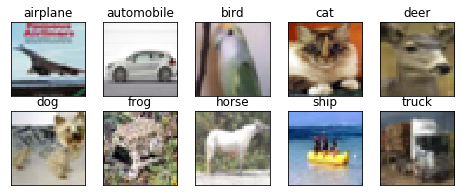

In [0]:
# Load cifar using the load data function
# The data is in the shape of (Batch_size, num_channel, width, height)
# np.unique returns unique class names

(train_features, train_labels), (test_features, test_labels) =  tfk.datasets.cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(num_classes)



# Visualization of some particular classes from the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5,1 + i, xticks=[], yticks=[])
    # gets the all the position of a particular class
    idx = np.where(train_labels[:]==i)[0]
    # using the idx we can find the corresponding image arrays
    features_idx = train_features[idx,::]
    # selects an img num by random
    img_num = np.random.randint(features_idx.shape[0])
    # gets the img array by img num
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Normalize data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# Convert class labels to binary class labels
train_labels = tfk.utils.to_categorical(train_labels, num_classes)
test_labels = tfk.utils.to_categorical(test_labels, num_classes)

In [0]:
# #z-score
# mean = np.mean(train_features,axis=(0,1,2,3))
# std = np.std(train_features,axis=(0,1,2,3))
# train_features = (train_features-mean)/(std+1e-7)
# test_features = (test_features-mean)/(std+1e-7)

### All Resnet definations go here

In [0]:
def resnet_block(x,conv_channel_size,output_size,stride_size):
  # todo add arguments
  """
  Args:

  """
  # bn follwedby relu
  x_original = x
  x = bn_with_relu(x)
  # conv 
  x = tfk.layers.Conv2D(conv_channel_size, 3 , padding='same', strides = stride_size[0])(x)
  # # bn follwedby relu
  x = bn_with_relu(x)
  # conv 
  x = tfk.layers.Conv2D(conv_channel_size, 3, padding='same', strides = stride_size[1])(x)
  # if channel size doesn't match we can't add
  # so perform 1x1 to get required channel size 
  if output_size != 'same':
    identity_tensor = tfk.layers.Conv2D(conv_channel_size, 1, padding='same',strides = stride_size[0])(x_original)
    identity_tensor = tfk.layers.BatchNormalization()(identity_tensor)
  else:
    identity_tensor = x_original
  x = tfk.layers.add([x,identity_tensor])
  return x


def bn_with_relu(x):
  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Activation(tf.nn.relu)(x)
  return x

In [0]:
input_shape = (img_rows,img_cols,img_channels)
input_tensor = tfk.layers.Input(input_shape)
x = tfk.layers.Conv2D(16, 3, padding='same')(input_tensor)
# todo add comments
x  = resnet_block(x,16,'not_same',[1,1])
x  = resnet_block(x,16,'same',[1,1])
x  = resnet_block(x,32,'not_same',[1,1])
x  = resnet_block(x,32,'same',[1,1])

# x  = tfk.layers.MaxPooling2D(2,2)(x)
x  = resnet_block(x,64,'not_same',[2,1])
x  = resnet_block(x,64,'same',[1,1])

# x  = tfk.layers.MaxPooling2D(2,2)(x)
x  = resnet_block(x,128,'not_same',[2,1])
x  = resnet_block(x,128,'same',[1,1])

x = tfk.layers.Conv2D(10,1)(x)
x = tfk.layers.GlobalAveragePooling2D()(x)
x = tfk.layers.Activation(tf.nn.softmax)(x)
model = tfk.models.Model(input_tensor,x)

In [0]:
model = tfk.models.Model(input_tensor,x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [0]:
# count = 0
# for l in  model.layers:
#   # print(l.name)
#   if l.name.split('_')[0] == 'conv2d':
#     count += 1
# print(count)

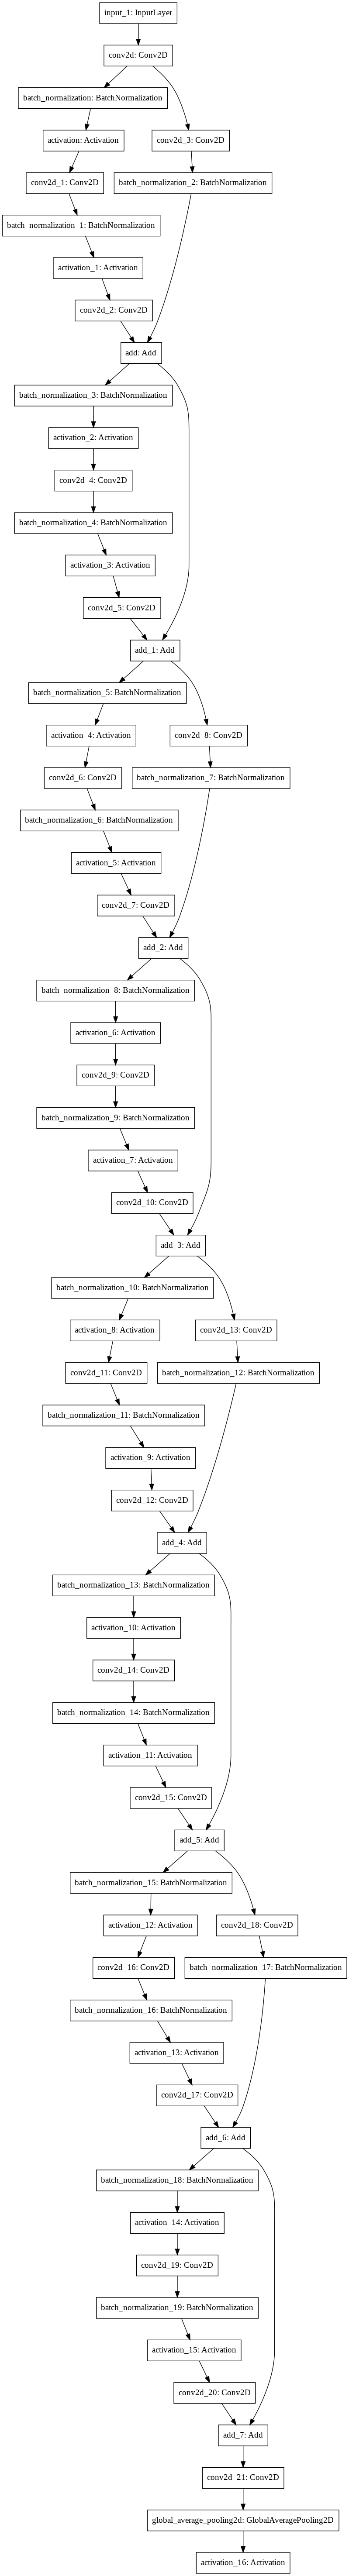

In [0]:
tfk.utils.plot_model(model)

In [0]:
# code is used from https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

def cutout_with_random_erasing(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):

    def random_crop(input_img):
      padded_img = tf.image.resize_with_crop_or_pad(input_img,40,40)
      cropped_image = tf.image.random_crop(padded_img, size=[32, 32, 3])
      return cropped_image.numpy()
    
    def eraser(input_img):
        input_img = random_crop(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


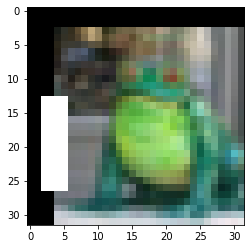

In [0]:
# test a image with cutout
eraser = cutout_with_random_erasing()

img = eraser(train_features[19])
plt.imshow(img)

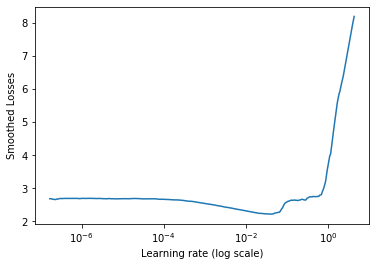

In [0]:
# lr_finder.plot_smoothed_loss()

In [0]:
################### Define the callbacks ###################

base_dir = '/content/drive/My Drive/EVA/Session13'

if not (os.path.exists(os.path.join(base_dir, 'weights'))):
    os.mkdir(os.path.join(base_dir, 'weights'))

filepath = os.path.join(base_dir,
                        'weights/weights-improvement-cutout-best.hdf5')

checkpoint = tfk.callbacks.ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Create datagenerate for trainingtrain_batches
datagen = tfk.preprocessing.image.ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,preprocessing_function=cutout_with_random_erasing(v_l=0.1, v_h=0.3))

In [0]:
model.compile(optimizer = tf.optimizers.SGD(lr=.005, momentum=.9, decay=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
start = time.time()

# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128), epochs = 300,
                                 validation_data = (test_features, test_labels), verbose=1,
                                callbacks=[checkpoint])
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/300
390/391 [============================>.] - ETA: 0s - loss: 1.6808 - accuracy: 0.3805
Epoch 00001: val_accuracy improved from -inf to 0.36290, saving model to /content/drive/My Drive/EVA/Session13/weights/weights-improvement-cutout-best.hdf5
391/391 [==============================] - 149s 381ms/step - loss: 1.6802 - accuracy: 0.3807 - val_loss: 1.7570 - val_accuracy: 0.3629
Epoch 2/300
390/391 [============================>.] - ETA: 0s - loss: 1.3401 - accuracy: 0.5137
Epoch 00002: val_accuracy improved from 0.36290 to 0.54770, saving model to /content/drive/My Drive/EVA/Session13/weights/weights-improvement-cutout-best.hdf5
391/391 [==============================] - 141s 361ms/step - loss: 1.3402 - accuracy: 0.5137 - val_loss: 1.2734 - val_accuracy: 0.5477
Epoch 3/300
390/391 [============================>.] - ETA: 0s - loss: 1.1777 - accuracy: 0.5750
Epoch 00003: val_accuracy did not improve from 0.54770
391/391 [==============================] - 138s 353ms/step - loss: 1.

In [0]:
# cd '/content/drive/My Drive/EVA/Session13/'

/content/drive/My Drive/EVA/Session13
